![CMCC](http://cmcc.ufabc.edu.br/images/logo_site.jpg)
# **Regress�o Linear**

#### Este notebook mostra uma implementa��o b�sica de Regress�o Linear e o uso da biblioteca [MLlib](http://spark.apache.org/docs/1.4.0/api/python/pyspark.ml.html) do PySpark para a tarefa de regress�o na base de dados [Million Song Dataset](http://labrosa.ee.columbia.edu/millionsong/) do reposit�rio [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/YearPredictionMSD). Nosso objetivo � predizer o ano de uma m�sica atrav�s dos seus atributos de �udio.

#### ** Neste notebook: **
+  ####*Parte 1:* Leitura e *parsing* da base de dados
 + #### *Visualiza��o 1:* Atributos
 + #### *Visualiza��o 2:* Deslocamento das vari�veis de interesse
+  ####*Parte 2:* Criar um preditor de refer�ncia
 + #### *Visualiza��o 3:* Valores Preditos vs. Verdadeiros
+  ####*Parte 3:* Treinar e avaliar um modelo de regress�o linear
 + #### *Visualiza��o 4:* Erro de Treino
+  ####*Parte 4:* Treinar usando MLlib e ajustar os hiperpar�metros
 + #### *Visualiza��o 5:* Predi��es do Melhor modelo
 + #### *Visualiza��o 6:* Mapa de calor dos hiperpar�metros
+  ####*Parte 5:* Adicionando intera��es entre atributos
+  ####*Parte 6:* Aplicando na base de dados de Crimes de S�o Francisco
 
#### Para refer�ncia, consulte os m�todos relevantes do PySpark em [Spark's Python API](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD) e do NumPy em [NumPy Reference](http://docs.scipy.org/doc/numpy/reference/index.html)

### ** Parte 1: Leitura e *parsing* da base de dados**

#### ** (1a) Verificando os dados dispon�veis **

#### Os dados da base que iremos utilizar est�o armazenados em um arquivo texto. No primeiro passo vamos transformar os dados textuais em uma RDD e verificar a formata��o dos mesmos. Altere a segunda c�lula para verificar quantas amostras existem nessa base de dados utilizando o m�todo  [count method](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.count).

#### Reparem que o r�tulo dessa base � o primeiro registro, representando o ano.

In [13]:
# carregar base de dados
from pyspark import SparkContext
import os.path

fileName = os.path.join(os.getcwd(), 'millionsong.txt')

numPartitions = 2

sc = SparkContext.getOrCreate()
rawData = sc.textFile(fileName, numPartitions)

In [15]:
# EXERCICIO
numPoints = rawData.count()
print (numPoints)
samplePoints = rawData.take(5)
print (samplePoints)

6724


[u'2001.0,0.884123733793,0.610454259079,0.600498416968,0.474669212493,0.247232680947,0.357306088914,0.344136412234,0.339641227335,0.600858840135,0.425704689024,0.60491501652,0.419193351817', u'2001.0,0.854411946129,0.604124786151,0.593634078776,0.495885413963,0.266307830936,0.261472105188,0.506387076327,0.464453565511,0.665798573683,0.542968988766,0.58044428577,0.445219373624', u'2001.0,0.908982970575,0.632063159227,0.557428975183,0.498263761394,0.276396052336,0.312809861625,0.448530069406,0.448674249968,0.649791323916,0.489868662682,0.591908113534,0.4500023818', u'2001.0,0.842525219898,0.561826888508,0.508715259692,0.443531142139,0.296733836002,0.250213568176,0.488540873206,0.360508747659,0.575435243185,0.361005878554,0.678378718617,0.409036786173', u'2001.0,0.909303285534,0.653607720915,0.585580794716,0.473250503005,0.251417011835,0.326976795524,0.40432273022,0.371154511756,0.629401917965,0.482243251755,0.566901413923,0.463373691946']


In [17]:
# TEST Load and check the data (1a)
assert numPoints==6724, 'incorrect value for numPoints'
print("OK")
assert len(samplePoints)==5, 'incorrect length for samplePoints'
print("OK")

OK
OK


#### ** (1b) Usando `LabeledPoint` **
#### Na MLlib, bases de dados rotuladas devem ser armazenadas usando o objeto [LabeledPoint](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LabeledPoint).  Escreva a fun��o `parsePoint` que recebe como entrada uma amostra de dados, transforma os dados usandoo comando [unicode.split](https://docs.python.org/2/library/string.html#string.split), em seguida mapeando para `float` e retorna um `LabeledPoint`.  

#### Aplique essa fun��o na vari�vel `samplePoints` da c�lula anterior e imprima os atributos e r�tulo utilizando os atributos `LabeledPoint.features` e `LabeledPoint.label`. Finalmente, calcule o n�mero de atributos nessa base de dados.

In [18]:
from pyspark.mllib.regression import LabeledPoint
import numpy as np

# Here is a sample raw data point:
# '2001.0,0.884,0.610,0.600,0.474,0.247,0.357,0.344,0.33,0.600,0.425,0.60,0.419'
# In this raw data point, 2001.0 is the label, and the remaining values are features

In [19]:
# EXERCICIO
def parsePoint(line):
    """Converts a comma separated unicode string into a `LabeledPoint`.

    Args:
        line (unicode): Comma separated unicode string where the first element is the label and the
            remaining elements are features.

    Returns:
        LabeledPoint: The line is converted into a `LabeledPoint`, which consists of a label and
            features.
    """
    Point = line.split(',')
    return LabeledPoint(Point[0],[Point[i] for i in range(1,len(Point))])

parsedSamplePoints = list(map(parsePoint,samplePoints))
firstPointFeatures = parsedSamplePoints[0].features
firstPointLabel = parsedSamplePoints[0].label
print (firstPointFeatures, firstPointLabel)

d = len(firstPointFeatures)
print (d)

(DenseVector([0.8841, 0.6105, 0.6005, 0.4747, 0.2472, 0.3573, 0.3441, 0.3396, 0.6009, 0.4257, 0.6049, 0.4192]), 2001.0)
12


In [20]:
# TEST Using LabeledPoint (1b)
assert isinstance(firstPointLabel, float), 'label must be a float'
expectedX0 = [0.8841,0.6105,0.6005,0.4747,0.2472,0.3573,0.3441,0.3396,0.6009,0.4257,0.6049,0.4192]
assert np.allclose(expectedX0, firstPointFeatures, 1e-4, 1e-4), 'incorrect features for firstPointFeatures'
assert np.allclose(2001.0, firstPointLabel), 'incorrect label for firstPointLabel'
assert d == 12, 'incorrect number of features'
print("OK")

OK


#### **Visualiza��o 1: Atributos**

#### A pr�xima c�lula mostra uma forma de visualizar os atributos atrav�s de um mapa de calor. Nesse mapa mostramos os 50 primeiros objetos e seus atributos representados por tons de cinza, sendo o branco representando o valor 0 e o preto representando o valor 1.

#### Esse tipo de visualiza��o ajuda a perceber a varia��o dos valores dos atributos. Pouca mudan�a de tons significa que os valores daquele atributo apresenta uma vari�ncia baixa.

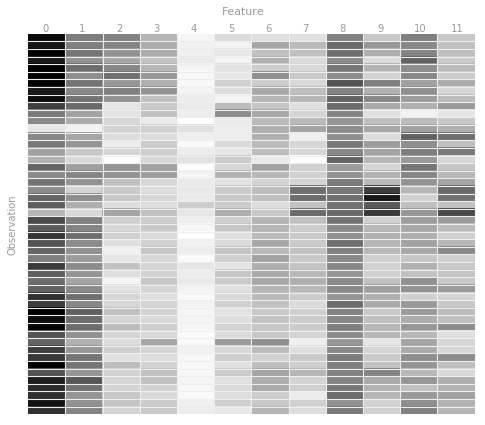

In [21]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

sampleMorePoints = rawData.take(50)

parsedSampleMorePoints = map(parsePoint, sampleMorePoints)
dataValues = list(map(lambda lp: lp.features.toArray(), parsedSampleMorePoints))

def preparePlot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                gridWidth=1.0):
    """Template for generating the plot layout."""
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

# generate layout and plot
fig, ax = preparePlot(np.arange(.5, 11, 1), np.arange(.5, 49, 1), figsize=(8,7), hideLabels=True,
                      gridColor='#eeeeee', gridWidth=1.1)
image = plt.imshow(dataValues,interpolation='nearest', aspect='auto', cmap=cm.Greys)
for x, y, s in zip(np.arange(-.125, 12, 1), np.repeat(-.75, 12), [str(x) for x in range(12)]):
    plt.text(x, y, s, color='#999999', size='10')
plt.text(4.7, -3, 'Feature', color='#999999', size='11'), ax.set_ylabel('Observation')
pass

#### **(1c) Deslocando os r�tulos **

#### Para melhor visualizar as solu��es obtidas, calcular o erro de predi��o e visualizar a rela��o dos atributos com os r�tulos, costuma-se deslocar os r�tulos para iniciarem em zero.

#### Como primeiro passo, aplique a fun��o `parsePoint` no RDD criado anteriormente, em seguida, crie uma RDD apenas com o `.label` de cada amostra. Finalmente, calcule os valores m�nimos e m�ximos.

In [22]:
# EXERCICIO
parsedDataInit = rawData.map(parsePoint)
onlyLabels = parsedDataInit.map(lambda x: x.label)
minYear = onlyLabels.min()
maxYear = onlyLabels.max()
print maxYear, minYear

2011.0 1922.0


In [24]:
# TEST Find the range (1c)
assert len(parsedDataInit.take(1)[0].features)==12, 'unexpected number of features in sample point'
sumFeatTwo = parsedDataInit.map(lambda lp: lp.features[2]).sum()
assert np.allclose(sumFeatTwo, 3158.96224351), 'parsedDataInit has unexpected values'
yearRange = maxYear - minYear
assert yearRange == 89, 'incorrect range for minYear to maxYear'
print("OK")

OK


In [24]:
# EXERCICIO: subtraia os labels do valor m�nimo
parsedData = parsedDataInit.map(lambda xy: LabeledPoint(xy.label-minYear,xy.features))

# Should be a LabeledPoint
print type(parsedData.take(1)[0])
# View the first point
print ('\n{0}'.format(parsedData.take(1)))

<class 'pyspark.mllib.regression.LabeledPoint'>



[LabeledPoint(79.0, [0.884123733793,0.610454259079,0.600498416968,0.474669212493,0.247232680947,0.357306088914,0.344136412234,0.339641227335,0.600858840135,0.425704689024,0.60491501652,0.419193351817])]


In [25]:
# TEST Shift labels (1d)
oldSampleFeatures = parsedDataInit.take(1)[0].features
newSampleFeatures = parsedData.take(1)[0].features
assert np.allclose(oldSampleFeatures, newSampleFeatures), 'new features do not match old features'
sumFeatTwo = parsedData.map(lambda lp: lp.features[2]).sum()
assert np.allclose(sumFeatTwo, 3158.96224351), 'parsedData has unexpected values'
minYearNew = parsedData.map(lambda lp: lp.label).min()
maxYearNew = parsedData.map(lambda lp: lp.label).max()
assert minYearNew == 0, 'incorrect min year in shifted data'
assert maxYearNew == 89, 'incorrect max year in shifted data'
print("OK")

OK


#### ** (1d) Conjuntos de treino, valida��o e teste **

#### Como pr�ximo passo, vamos dividir nossa base de dados em conjunto de treino, valida��o e teste conforme discutido em sala de aula. Use o m�todo [randomSplit method](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.randomSplit) com os pesos (weights) e a semente aleat�ria (seed) especificados na c�lula abaixo parar criar a divis�o das bases. Em seguida, utilizando o m�todo `cache()` fa�a o pr�-armazenamento da base processada.

#### Esse comando faz o processamento da base atrav�s das transforma��es e armazena em um novo RDD que pode ficar armazenado em mem�ria, se couber, ou em um arquivo tempor�rio.

In [26]:
# EXERCICIO
weights = [.8, .1, .1]
seed = 42
parsedTrainData, parsedValData, parsedTestData = parsedData.randomSplit(weights,seed)
parsedTrainData.cache()
parsedValData.cache()
parsedTestData.cache()
nTrain = parsedTrainData.count()
nVal = parsedValData.count()
nTest = parsedTestData.count()

print (nTrain, nVal, nTest, nTrain + nVal + nTest)
print (parsedData.count())

(5371, 682, 671, 6724)


6724


In [27]:
# TEST Training, validation, and test sets (1e)
assert parsedTrainData.getNumPartitions() == numPartitions, 'parsedTrainData has wrong number of partitions'
assert parsedValData.getNumPartitions() == numPartitions, 'parsedValData has wrong number of partitions'
assert parsedTestData.getNumPartitions() == numPartitions,'parsedTestData has wrong number of partitions'
assert len(parsedTrainData.take(1)[0].features) == 12, 'parsedTrainData has wrong number of features'
sumFeatTwo = (parsedTrainData
              .map(lambda lp: lp.features[2])
              .sum())
sumFeatThree = (parsedValData
                .map(lambda lp: lp.features[3])
                .reduce(lambda x, y: x + y))
sumFeatFour = (parsedTestData
               .map(lambda lp: lp.features[4])
               .reduce(lambda x, y: x + y))
assert np.allclose([sumFeatTwo, sumFeatThree, sumFeatFour],2526.87757656, 297.340394298, 184.235876654), 'parsed Train, Val, Test data has unexpected values'
assert nTrain + nVal + nTest == 6724, 'unexpected Train, Val, Test data set size'
assert nTrain == 5359, 'unexpected value for nTrain'
assert nVal == 678, 'unexpected value for nVal'
assert nTest == 687, 'unexpected value for nTest'
print("OK")

AssertionError: unexpected value for nTrain

### ** Part 2: Criando o modelo de *baseline* **

#### **(2a) R�tulo m�dio **

#### O baseline � �til para verificarmos que nosso modelo de regress�o est� funcionando. Ele deve ser um modelo bem simples que qualquer algoritmo possa fazer melhor.

#### Um baseline muito utilizado � fazer a mesma predi��o independente dos dados analisados utilizando o r�tulo m�dio do conjunto de treino. Calcule a m�dia dos r�tulos deslocados para a base de treino, utilizaremos esse valor posteriormente para comparar o erro de predi��o.  Use um m�todo apropriado para essa tarefa, consulte o [RDD API](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD).

In [28]:
# EXERCICIO

averageTrainYear = parsedTrainData.map(lambda x: x.label).mean()
print averageTrainYear

53.9316700801


In [29]:
# TEST Average label (2a)
assert np.allclose(averageTrainYear, 53.6792311), 'incorrect value for averageTrainYear'
print("OK")

AssertionError: incorrect value for averageTrainYear

#### **(2b) Erro quadr�tico m�dio **

#### Para comparar a performance em problemas de regress�o, geralmente � utilizado o Erro Quadr�tico M�dio ([RMSE](http://en.wikipedia.org/wiki/Root-mean-square_deviation)).  Implemente uma fun��o que calcula o RMSE a partir de um RDD de tuplas (r�tulo, predi��o).

In [30]:
# EXERCICIO
def squaredError(label, prediction):
    """Calculates the the squared error for a single prediction.

    Args:
        label (float): The correct value for this observation.
        prediction (float): The predicted value for this observation.

    Returns:
        float: The difference between the `label` and `prediction` squared.
    """
    return (label - prediction)**2

def calcRMSE(labelsAndPreds):
    """Calculates the root mean squared error for an `RDD` of (label, prediction) tuples.

    Args:
        labelsAndPred (RDD of (float, float)): An `RDD` consisting of (label, prediction) tuples.

    Returns:
        float: The square root of the mean of the squared errors.
    """
    return (labelsAndPreds.map(lambda x: squaredError(x[0],x[1]))\
                          .sum()/labelsAndPreds.count()) ** 0.5

labelsAndPreds = sc.parallelize([(3., 1.), (1., 2.), (2., 2.)])
# RMSE = sqrt[((3-1)^2 + (1-2)^2 + (2-2)^2) / 3] = 1.291
exampleRMSE = calcRMSE(labelsAndPreds)
print (exampleRMSE)

1.29099444874


In [31]:
# TEST Root mean squared error (2b)
assert np.allclose(squaredError(3, 1), 4.), 'incorrect definition of squaredError'
assert np.allclose(exampleRMSE, 1.29099444874), 'incorrect value for exampleRMSE'
print("OK")

OK


#### **(2c) RMSE do baseline para os conjuntos de treino, valida��o e teste **

#### Vamos calcular o RMSE para nossa baseline. Primeiro crie uma RDD de (r�tulo, predi��o) para cada conjunto, e ent�o chame a fun��o `calcRMSE`.

In [32]:
# EXERCICIO
labelsAndPredsTrain = parsedTrainData.map(lambda x: (x.label,averageTrainYear))
rmseTrainBase = calcRMSE(labelsAndPredsTrain)

labelsAndPredsVal = parsedValData.map(lambda x: (x.label,averageTrainYear))
rmseValBase = calcRMSE(labelsAndPredsVal)

labelsAndPredsTest = parsedTestData.map(lambda x: (x.label,averageTrainYear))
rmseTestBase = calcRMSE(labelsAndPredsTest)

print ('Baseline Train RMSE = {0:.3f}'.format(rmseTrainBase))
print ('Baseline Validation RMSE = {0:.3f}'.format(rmseValBase))
print ('Baseline Test RMSE = {0:.3f}'.format(rmseTestBase))

Baseline Train RMSE = 21.306
Baseline Validation RMSE = 21.586
Baseline Test RMSE = 22.137


In [33]:
# TEST Training, validation and test RMSE (2c)
assert np.allclose([rmseTrainBase, rmseValBase, rmseTestBase],[21.506125957738682, 20.877445428452468, 21.260493955081916]), 'incorrect RMSE value'
print("OK")

AssertionError: incorrect RMSE value

#### ** Visualiza��o 2: Predi��o vs. real **

#### Vamos visualizar as predi��es no conjunto de valida��o. Os gr�ficos de dispers�o abaixo plotam os pontos com a coordenada X sendo o valor predito pelo modelo e a coordenada Y o valor real do r�tulo.

#### O primeiro gr�fico mostra a situa��o ideal, um modelo que acerta todos os r�tulos. O segundo gr�fico mostra o desempenho do modelo baseline. As cores dos pontos representam o erro quadr�tico daquela predi��o, quanto mais pr�xima do laranja, maior o erro.

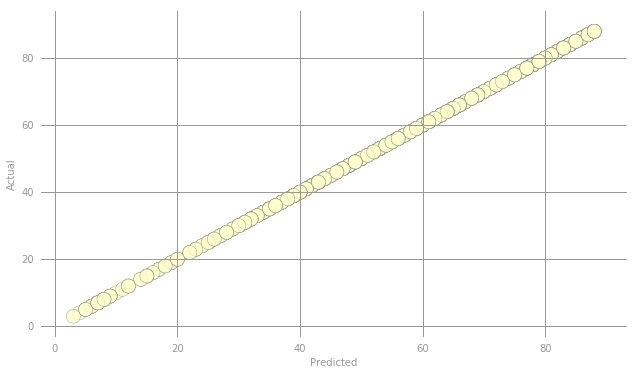

In [34]:
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import get_cmap
cmap = get_cmap('YlOrRd')
norm = Normalize()

actual = np.asarray(parsedValData
                    .map(lambda lp: lp.label)
                    .collect())
error = np.asarray(parsedValData
                   .map(lambda lp: (lp.label, lp.label))
                   .map(lambda lp: squaredError(lp[0], lp[1]))
                   .collect())
clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = preparePlot(np.arange(0, 100, 20), np.arange(0, 100, 20))
plt.scatter(actual, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=0.5)
ax.set_xlabel('Predicted'), ax.set_ylabel('Actual')
pass

(Text(0.5,0,u'Predicted'), Text(0,0.5,u'Actual'))

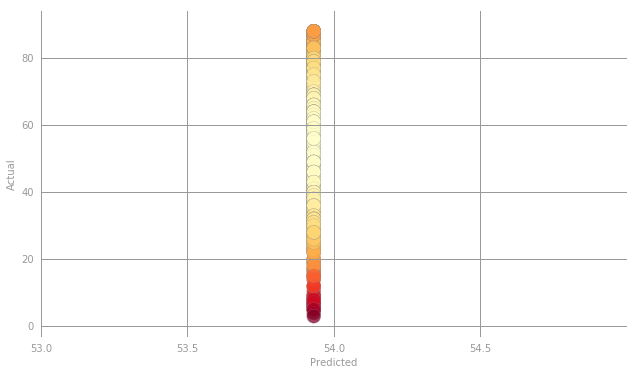

In [35]:
predictions = np.asarray(parsedValData
                         .map(lambda lp: averageTrainYear)
                         .collect())
error = np.asarray(parsedValData
                   .map(lambda lp: (lp.label, averageTrainYear))
                   .map(lambda lp: squaredError(lp[0], lp[1]))
                   .collect())
norm = Normalize()
clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = preparePlot(np.arange(53.0, 55.0, 0.5), np.arange(0, 100, 20))
ax.set_xlim(53, 55)
plt.scatter(predictions, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=0.3)
ax.set_xlabel('Predicted'), ax.set_ylabel('Actual')

### ** Parte 3: Treinando e avaliando o modelo de regress�o linear **

#### ** (3a) Gradiente do erro **

#### Vamos implementar a regress�o linear atrav�s do gradiente descendente.
#### Lembrando que para atualizar o peso da regress�o linear fazemos: $$ \scriptsize \mathbf{w}_{i+1} = \mathbf{w}_i - \alpha_i \sum_j (\mathbf{w}_i^\top\mathbf{x}_j  - y_j) \mathbf{x}_j \,.$$ onde $ \scriptsize i $ � a itera��o do algoritmo, e $ \scriptsize j $ � o objeto sendo observado no momento.

#### Primeiro, implemente uma fun��o que calcula esse gradiente do erro para certo objeto: $ \scriptsize (\mathbf{w}^\top \mathbf{x} - y) \mathbf{x} \, ,$ e teste a fun��o em dois exemplos. Use o m�todo `DenseVector` [dot](http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.linalg.DenseVector.dot) para representar a lista de atributos (ele tem funcionalidade parecida com o `np.array()`).

In [36]:
from pyspark.mllib.linalg import DenseVector

In [37]:
# EXERCICIO
def gradientSummand(weights, lp):
    """Calculates the gradient summand for a given weight and `LabeledPoint`.

    Note:
        `DenseVector` behaves similarly to a `numpy.ndarray` and they can be used interchangably
        within this function.  For example, they both implement the `dot` method.

    Args:
        weights (DenseVector): An array of model weights (betas).
        lp (LabeledPoint): The `LabeledPoint` for a single observation.

    Returns:
        DenseVector: An array of values the same length as `weights`.  The gradient summand.
    """

    return (weights.dot(lp.features) - lp.label)*lp.features

exampleW = DenseVector([1, 1, 1])
exampleLP = LabeledPoint(2.0, [3, 1, 4])

summandOne = gradientSummand(exampleW, exampleLP)
print (summandOne)

exampleW = DenseVector([.24, 1.2, -1.4])
exampleLP = LabeledPoint(3.0, [-1.4, 4.2, 2.1])
summandTwo = gradientSummand(exampleW, exampleLP)
print (summandTwo)

[18.0,6.0,24.0]
[1.7304000000000002,-5.191200000000001,-2.5956000000000006]


In [38]:
# TEST Gradient summand (3a)
assert np.allclose(summandOne, [18., 6., 24.]), 'incorrect value for summandOne'
assert np.allclose(summandTwo, [1.7304,-5.1912,-2.5956]), 'incorrect value for summandTwo'
print("OK")

OK


#### ** (3b) Use os pesos para fazer a predi��o **
#### Agora, implemente a fun��o  `getLabeledPredictions` que recebe como par�metro o conjunto de pesos e um `LabeledPoint` e retorna uma tupla (r�tulo, predi��o). Lembre-se que podemos predizer um r�tulo calculando o produto interno dos pesos com os atributos.

In [39]:
# EXERCICIO
def getLabeledPrediction(weights, observation):
    """Calculates predictions and returns a (label, prediction) tuple.

    Note:
        The labels should remain unchanged as we'll use this information to calculate prediction
        error later.

    Args:
        weights (np.ndarray): An array with one weight for each features in `trainData`.
        observation (LabeledPoint): A `LabeledPoint` that contain the correct label and the
            features for the data point.

    Returns:
        tuple: A (label, prediction) tuple.
    """
    return (observation.label, DenseVector(weights).dot(observation.features))

weights = np.array([1.0, 1.5])
predictionExample = sc.parallelize([LabeledPoint(2, np.array([1.0, .5])),
                                    LabeledPoint(1.5, np.array([.5, .5]))])
labelsAndPredsExample = predictionExample.map(lambda lp: getLabeledPrediction(weights, lp))
print (labelsAndPredsExample.collect())

[(2.0, 1.75), (1.5, 1.25)]


In [40]:
# TEST Use weights to make predictions (3b)
assert labelsAndPredsExample.collect() == [(2.0, 1.75), (1.5, 1.25)], 'incorrect definition for getLabeledPredictions'
print("OK")

OK


#### ** (3c) Gradiente descendente **
#### Finalmente, implemente o algoritmo gradiente descendente para regress�o linear e teste a fun��o em um exemplo.

In [41]:
# EXERCICIO
def linregGradientDescent(trainData, numIters):
    """Calculates the weights and error for a linear regression model trained with gradient descent.

    Note:
        `DenseVector` behaves similarly to a `numpy.ndarray` and they can be used interchangably
        within this function.  For example, they both implement the `dot` method.

    Args:
        trainData (RDD of LabeledPoint): The labeled data for use in training the model.
        numIters (int): The number of iterations of gradient descent to perform.

    Returns:
        (np.ndarray, np.ndarray): A tuple of (weights, training errors).  Weights will be the
            final weights (one weight per feature) for the model, and training errors will contain
            an error (RMSE) for each iteration of the algorithm.
    """
    # The length of the training data
    n = trainData.count()
    # The number of features in the training data
    t = trainData.take(1)
    d = len(t[0].features)
    w = np.zeros(d)
    alpha = 1.0
    # We will compute and store the training error after each iteration
    errorTrain = np.zeros(numIters)
    for i in range(numIters):
        # Use getLabeledPrediction from (3b) with trainData to obtain an RDD of (label, prediction)
        # tuples.  Note that the weights all equal 0 for the first iteration, so the predictions will
        # have large errors to start.
        
        labelsAndPredsTrain = trainData.map(lambda x: getLabeledPrediction(w,x))
        errorTrain[i] = calcRMSE(labelsAndPredsTrain)


        # Calculate the `gradient`.  Make use of the `gradientSummand` function you wrote in (3a).
        # Note that `gradient` sould be a `DenseVector` of length `d`.
        temporario  = trainData.map(lambda xy: gradientSummand(DenseVector(w), xy))
        gradient   = temporario.sum()
 

        # Update the weights
        alpha_i = alpha / (n * np.sqrt(i+1))
        w -= alpha_i*gradient
    return w, errorTrain

# create a toy dataset with n = 10, d = 3, and then run 5 iterations of gradient descent
# note: the resulting model will not be useful; the goal here is to verify that
# linregGradientDescent is working properly
exampleN = 10
exampleD = 3
exampleData = (sc
               .parallelize(parsedTrainData.take(exampleN))
               .map(lambda lp: LabeledPoint(lp.label, lp.features[0:exampleD])))
print (exampleData.take(1))
exampleNumIters = 5
exampleWeights, exampleErrorTrain = linregGradientDescent(exampleData, exampleNumIters)
print (exampleWeights)

[LabeledPoint(79.0, [0.884123733793,0.610454259079,0.600498416968])]


[48.88110449 36.01144093 30.25350092]


In [42]:
# TEST Gradient descent (3c)
expectedOutput = [48.20389904,  34.53243006, 30.60284959]
assert np.allclose(exampleWeights, expectedOutput), 'value of exampleWeights is incorrect'
expectedError = [79.72766145,  33.64762907,   9.46281696,   9.45486926,   9.44889147]
assert np.allclose(exampleErrorTrain, expectedError),'value of exampleErrorTrain is incorrect'
print("OK")

AssertionError: value of exampleWeights is incorrect

#### ** (3d) Treinando o modelo na base de dados **

#### Agora iremos treinar o modelo de regress�o linear na nossa base de dados de treino e calcular o RMSE na base de valida��o. Lembrem-se que n�o devemos utilizar a base de teste at� que o melhor par�metro do modelo seja escolhido. 

#### Para essa tarefa vamos utilizar as fun��es linregGradientDescent, getLabeledPrediction e calcRMSE j� implementadas.

In [43]:
# EXERCICIO
numIters = 50
weightsLR0, errorTrainLR0 = linregGradientDescent(parsedTrainData,50)
labelsAndPreds = parsedValData.map(lambda lp: getLabeledPrediction(weightsLR0, lp))
rmseValLR0 = calcRMSE(labelsAndPreds)

print ('Validation RMSE:\n\tBaseline = {0:.3f}\n\tLR0 = {1:.3f}'.format(rmseValBase, rmseValLR0))

Validation RMSE:
	Baseline = 21.586
	LR0 = 19.192


In [44]:
# TEST Train the model (3d)
expectedOutput = [ 22.64370481,  20.1815662,   -0.21620107,   8.53259099,   5.94821844,
  -4.50349235,  15.51511703,   3.88802901,   9.79146177,   5.74357056,
  11.19512589,   3.60554264]
assert np.allclose(weightsLR0, expectedOutput), 'incorrect value for weightsLR0'
print("OK")

AssertionError: incorrect value for weightsLR0

#### ** Visualiza��o 3: Erro de Treino **
#### Vamos verificar o comportamento do algoritmo durante as itera��es. Para isso vamos plotar um gr�fico em que o eixo x representa a itera��o e o eixo y o log do RMSE. O primeiro gr�fico mostra as primeiras 50 itera��es enquanto o segundo mostra as �ltimas 44 itera��es. Note que inicialmente o erro cai rapidamente, quando ent�o o gradiente descendente passa a fazer apenas pequenos ajustes.

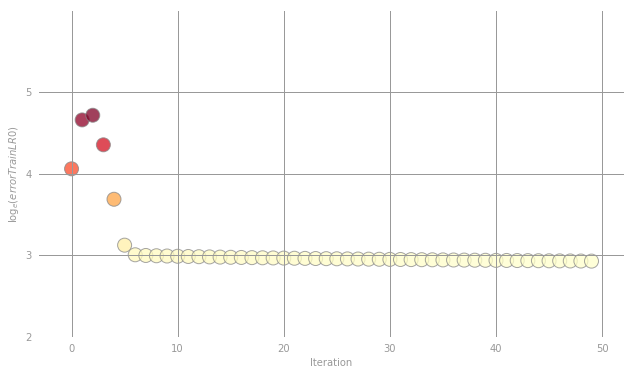

In [45]:

norm = Normalize()
clrs = cmap(np.asarray(norm(np.log(errorTrainLR0))))[:,0:3]

fig, ax = preparePlot(np.arange(0, 60, 10), np.arange(2, 6, 1))
ax.set_ylim(2, 6)
plt.scatter(list(range(0, numIters)), np.log(errorTrainLR0), s=14**2, c=clrs, edgecolors='#888888', alpha=0.75)
ax.set_xlabel('Iteration'), ax.set_ylabel(r'$\log_e(errorTrainLR0)$')
pass

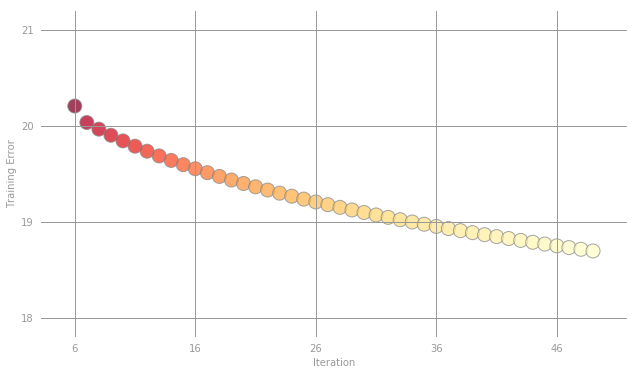

In [46]:
norm = Normalize()
clrs = cmap(np.asarray(norm(errorTrainLR0[6:])))[:,0:3]

fig, ax = preparePlot(np.arange(0, 60, 10), np.arange(17, 22, 1))
ax.set_ylim(17.8, 21.2)
plt.scatter(range(0, numIters-6), errorTrainLR0[6:], s=14**2, c=clrs, edgecolors='#888888', alpha=0.75)
ax.set_xticklabels(map(str, range(6, 66, 10)))
ax.set_xlabel('Iteration'), ax.set_ylabel(r'Training Error')
pass

### ** Part 4: Treino utilizando MLlib e Busca em Grade (Grid Search) **

#### **(4a) `LinearRegressionWithSGD` **

#### Nosso teste inicial j� conseguiu obter um desempenho melhor que o baseline, mas vamos ver se conseguimos fazer melhor introduzindo a ordenada de origem da reta al�m de outros ajustes no algoritmo.  MLlib [LinearRegressionWithSGD](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LinearRegressionWithSGD) implementa o mesmo algoritmo da parte (3b), mas de forma mais eficiente para o contexto distribu�do e com v�rias funcionalidades adicionais. 

#### Primeiro utilize a fun��o LinearRegressionWithSGD para treinar um modelo com regulariza��o L2 (Ridge) e com a ordenada de origem. Esse m�todo retorna um [LinearRegressionModel](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LinearRegressionModel).  

#### Em seguida, use os atributos [weights](http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LinearRegressionModel.weights) e  [intercept](http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LinearRegressionModel.intercept) para imprimir o modelo encontrado.

In [ ]:
from pyspark.mllib.regression import LinearRegressionWithSGD
# Values to use when training the linear regression model
numIters = 500  # iterations
alpha = 1.0  # step
miniBatchFrac = 1.0  # miniBatchFraction
reg = 1e-1  # regParam
regType = 'l2'  # regType
useIntercept = True  # intercept

In [48]:
# EXERCICIO
firstModel = LinearRegressionWithSGD.train(parsedTrainData, iterations = numIters, step = alpha, miniBatchFraction = 1.0,
                                          regParam=reg,regType=regType, intercept=useIntercept)

# weightsLR1 stores the model weights; interceptLR1 stores the model intercept
weightsLR1 = firstModel.weights
interceptLR1 = firstModel.intercept
print( weightsLR1, interceptLR1)

(DenseVector([15.9789, 13.9236, 0.7816, 6.0926, 3.9181, -2.3035, 10.3002, 3.0457, 7.2318, 4.658, 7.9888, 3.1782]), 13.376300981111008)


In [49]:
# TEST LinearRegressionWithSGD (4a)
expectedIntercept = 13.332056210482524
expectedWeights = [15.9694010246,13.9897244172,0.669349383773,6.24618402989,4.00932179503,-2.30176663131,10.478805422,3.06385145385,7.14414111075,4.49826819526,7.87702565069,3.00732146613]
assert np.allclose(interceptLR1, expectedIntercept), 'incorrect value for interceptLR1'
assert np.allclose(weightsLR1, expectedWeights), 'incorrect value for weightsLR1'
print("OK")

AssertionError: incorrect value for interceptLR1

#### **(4b) Predi��o**
#### Agora use o m�todo [LinearRegressionModel.predict()](http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LinearRegressionModel.predict) para fazer a predi��o de um objeto. Passe o atributo `features` de um `LabeledPoint` comp par�metro.

In [50]:
# EXERCICIO
samplePoint = parsedTrainData.take(1)[0]
samplePrediction = firstModel.predict(samplePoint.features)
print (samplePrediction)

56.58237966091762


In [51]:
# TEST Predict (4b)
assert np.allclose(samplePrediction, 56.4065674104), 'incorrect value for samplePrediction'

AssertionError: incorrect value for samplePrediction

#### ** (4c) Avaliar RMSE **

#### Agora avalie o desempenho desse modelo no teste de valida��o. Use o m�todo `predict()` para criar o RDD `labelsAndPreds` RDD, e ent�o use a fun��o `calcRMSE()` da Parte (2b) para calcular o RMSE.

In [52]:
# EXERCICIO
labelsAndPreds = parsedValData.map(lambda x: (x.label, firstModel.predict(x.features)))
rmseValLR1 = calcRMSE(labelsAndPreds)

print ('Validation RMSE:\n\tBaseline = {0:.3f}\n\tLR0 = {1:.3f}\n\tLR1 = {2:.3f}'.format(rmseValBase, rmseValLR0, rmseValLR1))

Validation RMSE:
	Baseline = 21.586
	LR0 = 19.192
	LR1 = 19.873


In [53]:
# TEST Evaluate RMSE (4c)
assert np.allclose(rmseValLR1, 19.025), 'incorrect value for rmseValLR1'

AssertionError: incorrect value for rmseValLR1

#### ** (4d) Grid search **
#### J� estamos superando o baseline em pelo menos dois anos na m�dia, vamos ver se encontramos um conjunto de par�metros melhor.  Fa�a um grid search para encontrar um bom par�metro de regulariza��o.  Tente valores para `regParam` dentro do conjunto `1e-10`, `1e-5`, e `1`.

In [57]:
# EXERCICIO
bestRMSE = rmseValLR1
bestRegParam = reg
bestModel = firstModel

numIters = 500
alpha = 1.0
miniBatchFrac = 1.0
for reg in [1e-10, 1e-5,1]:
    model = LinearRegressionWithSGD.train(parsedTrainData, numIters, alpha,
                                          miniBatchFrac, regParam=reg,
                                          regType='l2', intercept=True)
    labelsAndPreds = parsedValData.map(lambda x: (x.label, model.predict(x.features)))
    rmseValGrid = calcRMSE(labelsAndPreds)
    print (rmseValGrid)

    if rmseValGrid < bestRMSE:
        bestRMSE = rmseValGrid
        bestRegParam = reg
        bestModel = model
rmseValLRGrid = bestRMSE

print ('Validation RMSE:\n\tBaseline = {0:.3f}\n\tLR0 = {1:.3f}\n\tLR1 = {2:.3f}\n\tLRGrid = {3:.3f}'.format(rmseValBase, rmseValLR0, rmseValLR1, rmseValLRGrid))

17.483136270366916


17.48348186580435


23.800067293519586
Validation RMSE:
	Baseline = 21.586
	LR0 = 19.192
	LR1 = 19.873
	LRGrid = 17.483


In [57]:
# TEST Grid search (4d)
assert np.allclose(16.6813542516, rmseValLRGrid), 'incorrect value for rmseValLRGrid'

AssertionError: incorrect value for rmseValLRGrid

#### ** Visualiza��o 5: Predi��es do melhor modelo**
#### Agora, vamos criar um gr�fico para verificar o desempenho do melhor modelo. Reparem nesse gr�fico que a quantidade de pontos mais escuros reduziu bastante em rela��o ao baseline.

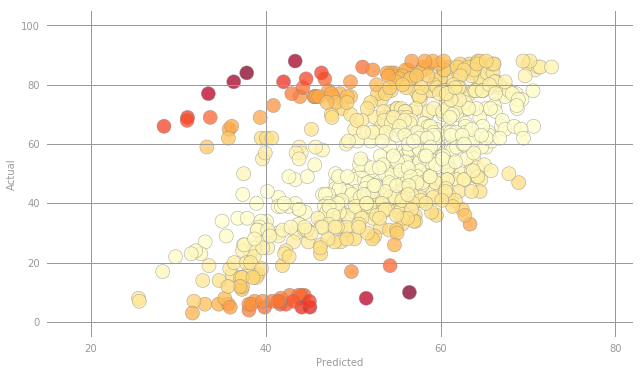

In [58]:
predictions = np.asarray(parsedValData
                         .map(lambda lp: bestModel.predict(lp.features))
                         .collect())
actual = np.asarray(parsedValData
                    .map(lambda lp: lp.label)
                    .collect())
error = np.asarray(parsedValData
                   .map(lambda lp: (lp.label, bestModel.predict(lp.features)))
                   .map(lambda lp: squaredError(lp[0], lp[1]))
                   .collect())

norm = Normalize()
clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = preparePlot(np.arange(0, 120, 20), np.arange(0, 120, 20))
ax.set_xlim(15, 82), ax.set_ylim(-5, 105)
plt.scatter(predictions, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=.5)
ax.set_xlabel('Predicted'), ax.set_ylabel(r'Actual')
pass

#### ** (4e) Grid Search para o valor de alfa e n�mero de itera��es **

#### Agora, vamos verificar diferentes valores para alfa e n�mero de itera��es para perceber o impacto desses par�metros em nosso modelo. Especificamente tente os valores  `1e-5` e `10` para `alpha` e os valores `500` e `5` para n�mero de itera��es. Avalie todos os modelos no conjunto de valda��o.  Reparem que com um valor baixo de alpha, o algoritmo necessita de muito mais itera��es para convergir ao �timo, enquanto um valor muito alto para alpha, pode fazer com que o algoritmo n�o encontre uma solu��o.

In [60]:
# EXERCICIO
reg = bestRegParam
modelRMSEs = []

for alpha in [1e-5, 10]:
    for numIters in [500, 5]:
        model = LinearRegressionWithSGD.train(parsedTrainData, numIters, alpha,
                                              miniBatchFrac, regParam=reg,
                                              regType='l2', intercept=True)
        labelsAndPreds = parsedValData.map(lambda lp: (lp.label, model.predict(lp.features)))
        rmseVal = calcRMSE(labelsAndPreds)
        print ('alpha = {0:.0e}, numIters = {1}, RMSE = {2:.3f}'.format(alpha, numIters, rmseVal))
        modelRMSEs.append(rmseVal)

alpha = 1e-05, numIters = 500, RMSE = 56.973


alpha = 1e-05, numIters = 5, RMSE = 56.973


alpha = 1e+01, numIters = 500, RMSE = 33110728225678993724249071515084334709948166884960756405762586052582656490821782231141326865198981397833205889386753818624.000


alpha = 1e+01, numIters = 5, RMSE = 355124752.221


In [60]:
# TEST Vary alpha and the number of iterations (4e)
expectedResults = sorted([57.487692757541318, 57.487692757541318, 352324534.65684682])
assert np.allclose(sorted(modelRMSEs)[:3], expectedResults), 'incorrect value for modelRMSEs'

AssertionError: incorrect value for modelRMSEs